In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [24]:
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None):
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieve thickness data
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > 2].iloc[0])

    data_name = namestr(data_list[0], globals())
    if concentration_info == True:
        conc = concentration
    else:
        conc = data_name.split('_')[2]
        if len(conc) > 2:
            conc = conc[:-2]
    if data_name.split('_')[1] == 'heating':
        heating = True
    else:
        heating = False
    mechanicalProperties = [float(conc), heating]
    
    #SET UP STRESS STRAIN CURVE
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))
    
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] >1]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

    #SPLINE MODEL
        splineGAM = LinearGAM(s(0))
        splineGAM.fit(data[['strain']], data['stress (bar)'])
        splineModel = splineGAM.predict(data[['strain']])
        plt.plot(data[['strain']], splineModel, color='black',label='Spline Model')

    #DERIVATIVE
        data['1st derivative'] = np.gradient(splineModel, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

        linear_regions = []
        start = 0
        slopes = data['1st derivative']
        for i in range(1, len(slopes)):
            if abs(slopes[i] - slopes[start]) < 0.00001:
                linear_regions.append((start, i))
                start = i
        linear_regions.append((start, len(slopes)))

        #for start, end in linear_regions:
            #plt.plot(data['strain'][start:end+1], data['stress (bar)'][start:end+1], color = 'blue', linewidth=3)
        
        plt.xlabel('strain')
        plt.ylabel('stress (bar)')
        plt.legend()
        plt.title('Stress Strain Curve')
        plt.show()

In [15]:
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None):
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieve thickness data
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > 2].iloc[0])

    data_name = namestr(data_list[0], globals())
    if concentration_info == True:
        conc = concentration
    else:
        conc = data_name.split('_')[2]
        if len(conc) > 2:
            conc = conc[:-2]
    if data_name.split('_')[1] == 'heating':
        heating = True
    else:
        heating = False
    mechanicalProperties = [float(conc), heating]
    
    #SET UP STRESS STRAIN CURVE
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))
    
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] >1]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

    #SPLINE MODEL
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        #print(gam.summary())
        plt.plot(data[['strain']], predictions, color='black',label='Spline Model')

    #DERIVATIVE
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

    #SEGMENT REGIONS
        #elastic region
        data['2nd derivative'].idxmin()            
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(changepoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]
        
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        # 2% offset line starting at strain of 0.02
        offset_strain = np.linspace(0.02, max(data['strain']), len(data['strain']))  # Ensure same range and resolution
        offset_stress = elasticModulus * (offset_strain - 0.02)  # Calculate stress for the offset line

        # Find intersection point
        yield_strength = None
        yield_strain = None
        for actual_strain, actual_stress in zip(data['strain'], predictions):
        # Check if actual stress exceeds any calculated offset stress at the same or previous strain levels
            if actual_stress >= np.interp(actual_strain, offset_strain, offset_stress):
                yield_strength = actual_stress
                yield_strain = actual_strain
            break

        #plateau & densification region
        regions = data[data['strain'] >= yield_strain]
        pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=4)
        pw_results = pw_fit.get_results()
        eval = None
        if pw_results['estimates'] != None:
            breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint3 = pw_results['estimates']['breakpoint4']['estimate']
            plateauRegion = regions[regions['strain'] <= breakpoint2]
            densificationRegion = regions[regions['strain'] >= breakpoint3]

        #plateau region
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

        #densification region
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

        #changepoint calculations
            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
            xDensification = data[changepoint <= data['strain']]
            if len(xDensification) > 0 and len(xPlateau) > 0:
                predPlateau = modelPlateau.predict(xPlateau[['strain']])
                predDensification = modelDensification.predict(xDensification[['strain']])

        #FITTING EVALUATION
                plateauModel = LinearGAM(s(0))
                plateauModel.fit(xPlateau[['strain']], xPlateau['stress (bar)'])
                plateauSpline = plateauModel.predict(xPlateau[['strain']])

                correlation_coefficient = np.corrcoef(plateauSpline, predPlateau)[0, 1]

                print("Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate:", correlation_coefficient)
                print("Elastic Modulus:", elasticModulus)
                print("Plateau Slope:", slopePlateau)
                
                rangeStart = yieldStrength - 3     #arbitrary range
                rangeEnd = yieldStrength + 3
                if rangeStart <= modelPlateau.predict(breakpoint1.reshape(1, -1)) <= rangeEnd and slopePlateau <= elasticModulus*1.25 and correlation_coefficient <= 0.98:
                    eval = True
                else:
                    eval = False

    #MATERIAL PROPERTIES
                dict = {"Thickness": thickness[i],
                        "Elastic Modulus":elasticModulus, 
                        "Yield Strength":yieldStrength, 
                        "Changepoint":changepoint, 
                        "Slope Plateau":slopePlateau, 
                        "Slope Densification":slopeDensification,
                        "Good Fit":eval}
                mechanicalProperties.append(dict)

    #FINAL GRAPH
                plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region')
                plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region")
                plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region")
        
        plt.title(data_name)
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

        print("Good Fit:", eval)

    #DERIVATIVE PLOT
        plt.plot(data[['strain']], data['2nd derivative'], label='2nd Derivative')
        plt.title('2nd Derivative')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    return mechanicalProperties

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8786826659622146
Elastic Modulus: 20.160039624559975
Plateau Slope: 19.53571285041424


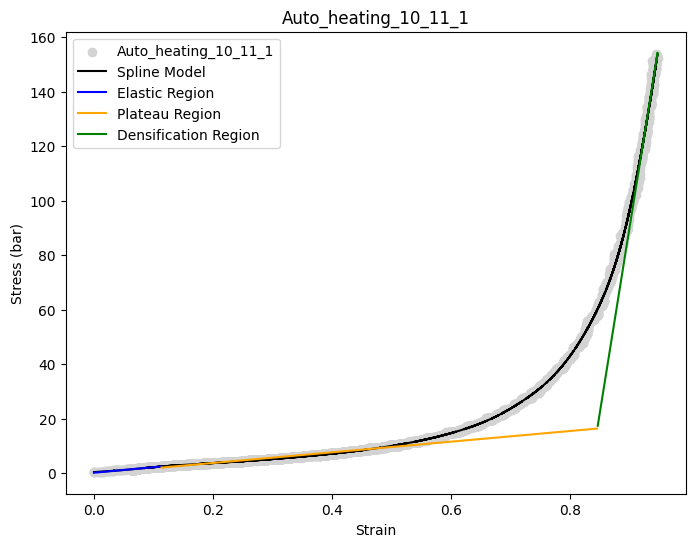

Good Fit: True


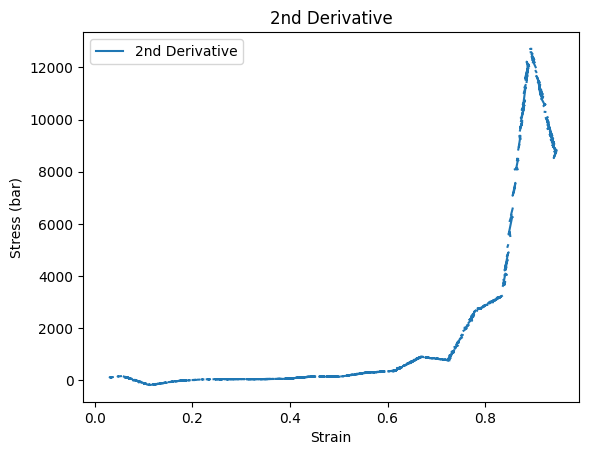

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8755057580350353
Elastic Modulus: 22.01254787671758
Plateau Slope: 18.24116916735247


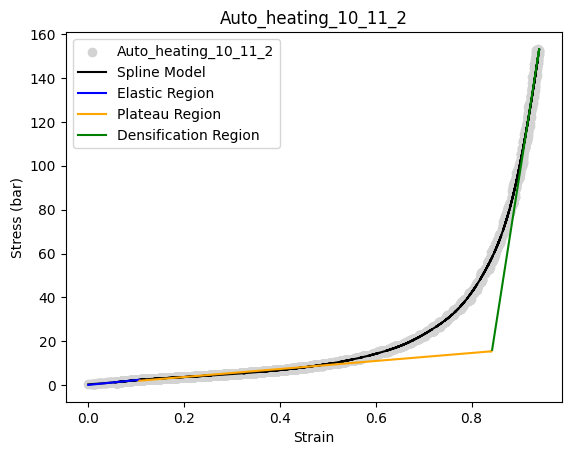

Good Fit: True


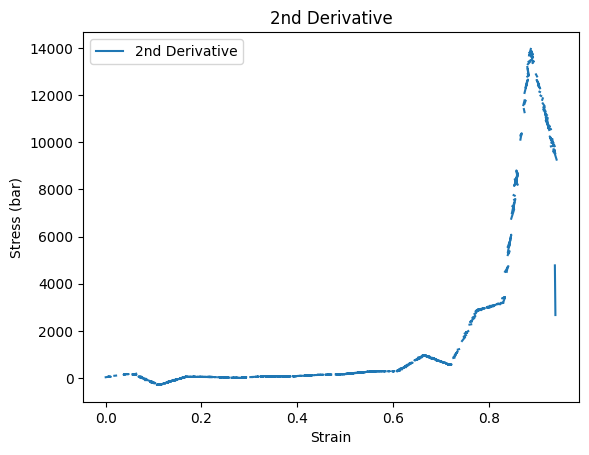

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.873214635485145
Elastic Modulus: 25.198608946885003
Plateau Slope: 17.984088333460512


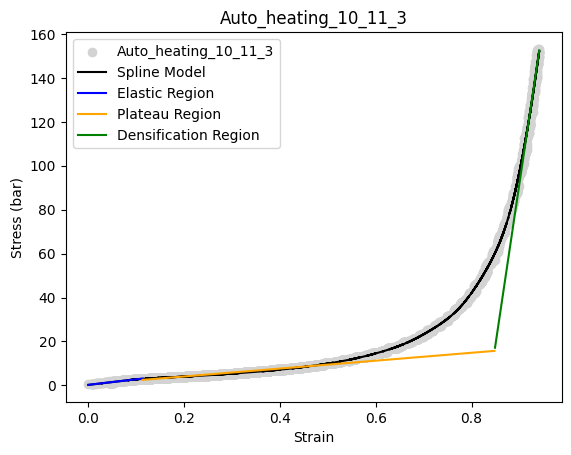

Good Fit: True


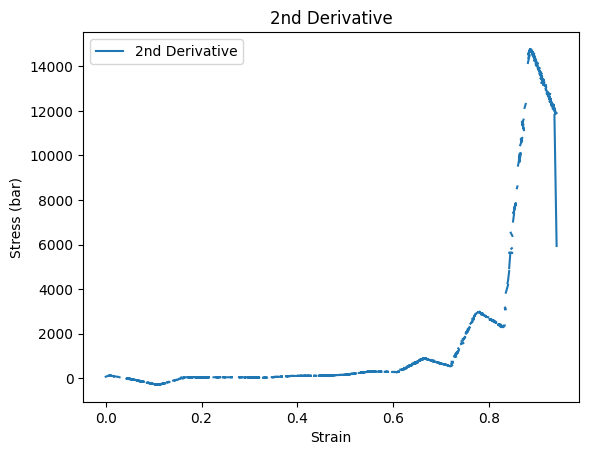

Plateau Region Correlation Coefficient Between Spline Model and Linear Estimate: 0.8752215331051413
Elastic Modulus: 21.905809267285022
Plateau Slope: 17.54512891316722


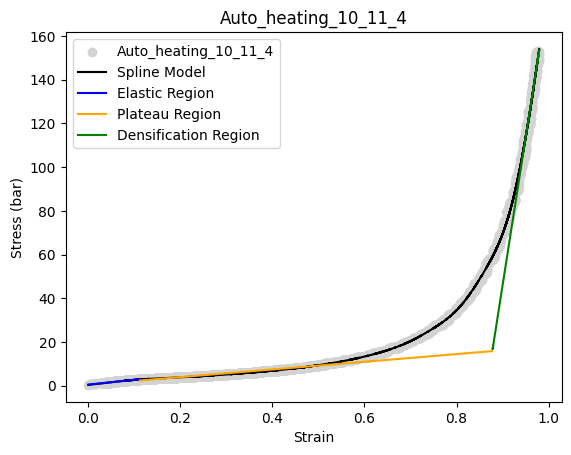

Good Fit: True


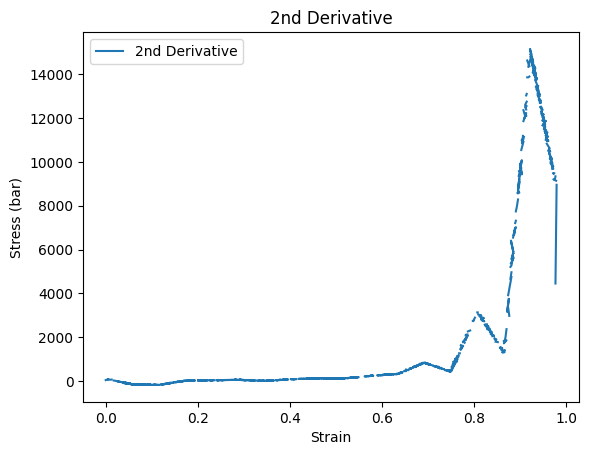

In [16]:
#GOOD DATA
Auto_heating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_heating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_heating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_heating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list_10_11 = [Auto_heating_10_11_1, Auto_heating_10_11_2, Auto_heating_10_11_3, Auto_heating_10_11_4]
properties_10_11 = interpretData(data_list_10_11, thickness_info = False, concentration_info = True, concentration = 10)